# An Introduction to HyperSpy: 
## The multi-dimensional data analysis toolbox

## *"Introdution to EELS Analysis in HyperSpy"*

#### Joshua Taillon - *June 5, 2019*

*Note: This notebook is heavily based off the ["EELS Analysis"](https://nbviewer.jupyter.org/github/hyperspy/hyperspy-demos/blob/master/electron_microscopy/EELS/EELS_analysis.ipynb) notebook from the [HyperSpy Demos](https://github.com/hyperspy/hyperspy-demos) repository*

This tutorial shows the various functionalities in HyperSpy which is used to analyse Electron Energy Loss Spectroscopy data, using EELS datasets from a perovskite oxide heterostructure.

It assumes some knowledge on how to use HyperSpy, like loading datasets and how the basic signals work.

This notebook requires:

HyperSpy 1.1 or later.

## Author

7/6/2016 Magnus Nord - Developed for HyperSpy workshop at Scandem conference 2016

## Changes

* 3/8/2016 Updated for HyperSpy 1.1. Added note about Gatan Digital Micrograph GOS.
* 28/5/2019 Updated for NIST Tutorials - Joshua Taillon and Andrew Herzing

## Table of contents

1. <a href='#spec_and_data'> Specimen & Data</a>
2. <a href='#simple_quant'> Simple quantification</a>
3. <a href='#curve_fitting_quant'> Curve fitting quantification</a>
4. <a href='#fine_structure_analysis'> Fine structure analysis</a>
5. <a href='#fine_structure_ok'> Fine structure oxygen-K edge</a>

# <a id='spec_and_data'></a>1. Specimen & Data

This notebook was used for the HyperSpy workshop at the Norwegian University of Science and Technology for the Scandem 2016 conference, 7 June 2016.

The data was acquired on a Jeol ARM200cF using a Gatan Quantum ER with DualEELS capabilities.

The data itself is from La<sub>0.7</sub>Sr<sub>0.3</sub>MnO<sub>3</sub> thin films deposited on SrTiO<sub>3</sub>. In the Fine Structure example parts of the film has been exposed to a very long electron beam exposure, inducing oxygen vacancies.

The datasets has been binned to reduce the file size and processing time.

# <a id='simple_quant'></a> 2. Simple quantification


Firstly we use some IPython magic to import the right plotting libraries, 

In [3]:
%matplotlib notebook

Then import HyperSpy. This might give two warnings "`WARNING:hyperspy_gui_traitsui`"; this can safely be ignored here.

In [4]:
import hyperspy.api as hs

First we take a look at an EELS line scan across an La<sub>0.7</sub>Sr<sub>0.3</sub>MnO<sub>3</sub>/SrTiO<sub>3</sub> thin film. The core loss data has several peaks: Ti-<em>L</em><sub>2,3</sub>, O-<em>K</em>, Mn-<em>L</em><sub>2,3</sub> and La-*M*<sub>4,5</sub>. We can navigate the line scan using the navigation window (Figure 1), and by moving the red line.

In [5]:
s = hs.load("data/LSMO_STO_linescan.hdf5")

<IPython.core.display.Javascript object>


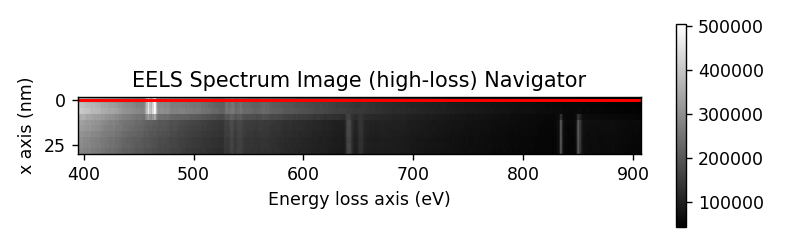

<IPython.core.display.Javascript object>


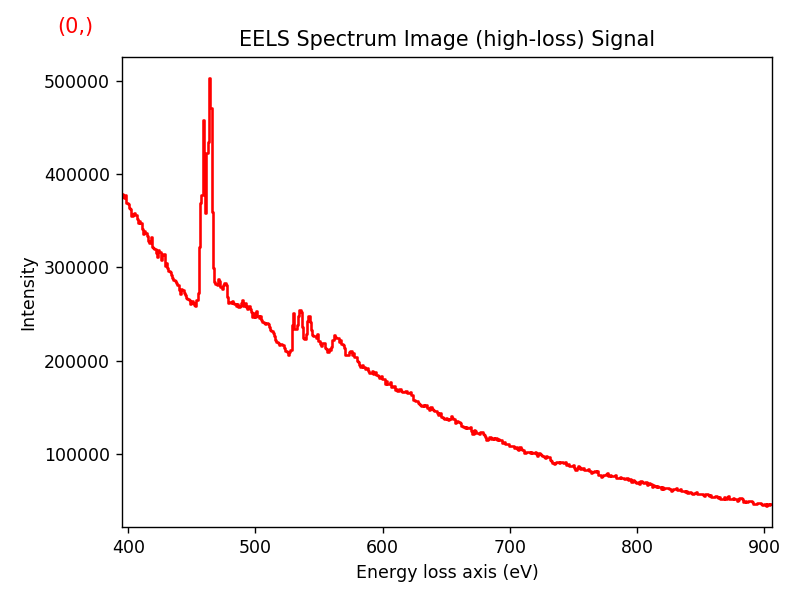

In [6]:
s.plot()

Now we can quantifiy the first edge (Ti-*L*<sub>2,3</sub>, 460 eV, 0-10 nm). Firstly by removing the background, then integrating the Ti-*L*<sub>2,3</sub> edge. Move the red line in the navigation figure towards the top part (0-10 nm, x axis). Then drag a span from about 400 to 440 eV in Figure 2.

Next, untick the "Fast" button in the dialog box under figure 2, and press Apply.

Note: sometimes the background removal doesn't work properly. If this happens, reload the data using the command above (`s = hs.load("data/LSMO_STO_linescan.hdf5")`. Then rerun the s.remove_background() command.

<IPython.core.display.Javascript object>


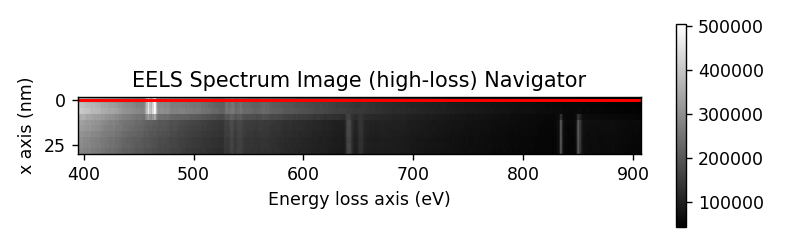

<IPython.core.display.Javascript object>


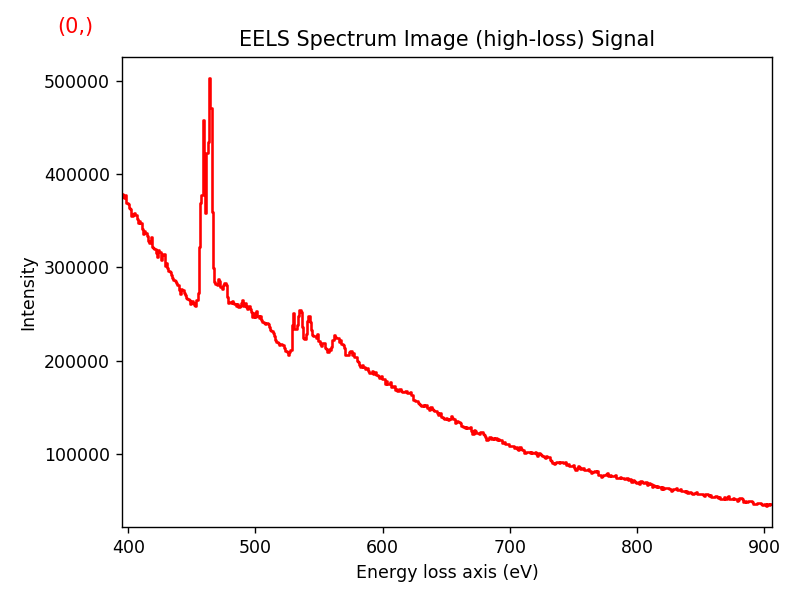

In [7]:
s.remove_background(fast=False)

To integrate the Ti-*L*<sub>2,3</sub> edge interactively we can use a region of interest:

<IPython.core.display.Javascript object>


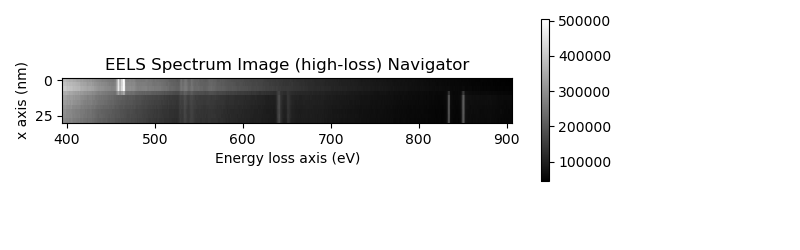

<IPython.core.display.Javascript object>


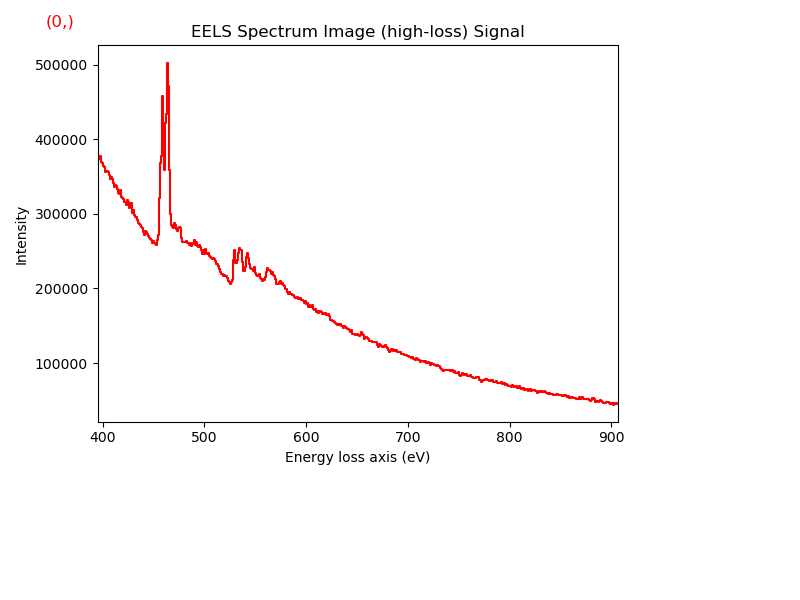

In [10]:
roi = hs.roi.SpanROI(left=450, right=600)
s.plot()
roi.add_widget(s, axes=["Energy loss"])

Finally, to integrate the signal in the selected ROI:

In [11]:
s_ti = s.isig[roi].integrate1D(axis="Energy loss")

<IPython.core.display.Javascript object>


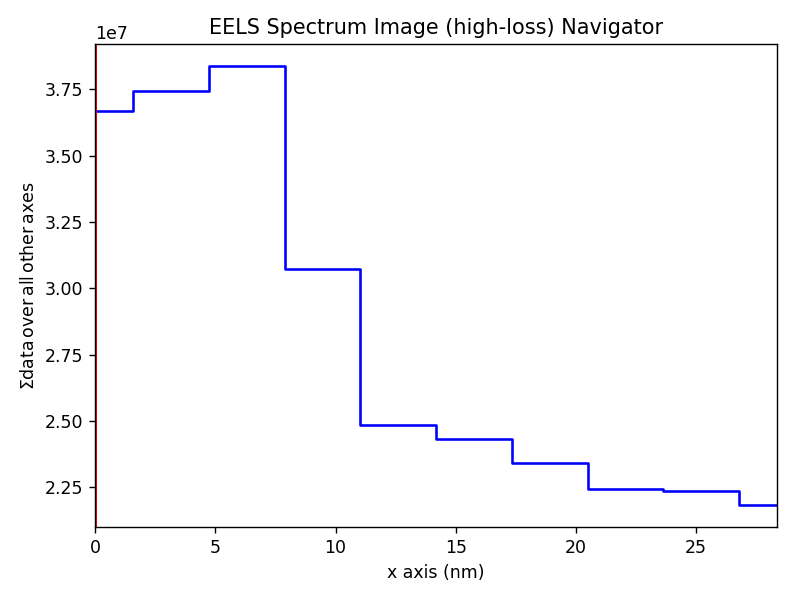

In [12]:
s_ti.plot()

Notice that we can also perform the same operations in one single line if interactivity is not required:

In [13]:
s = hs.load("data/LSMO_STO_linescan.hdf5")

In [14]:
s_ti = s.remove_background(signal_range=(405.,448.), fast=False).isig[448.:480.].integrate1D(axis=1)

<IPython.core.display.Javascript object>


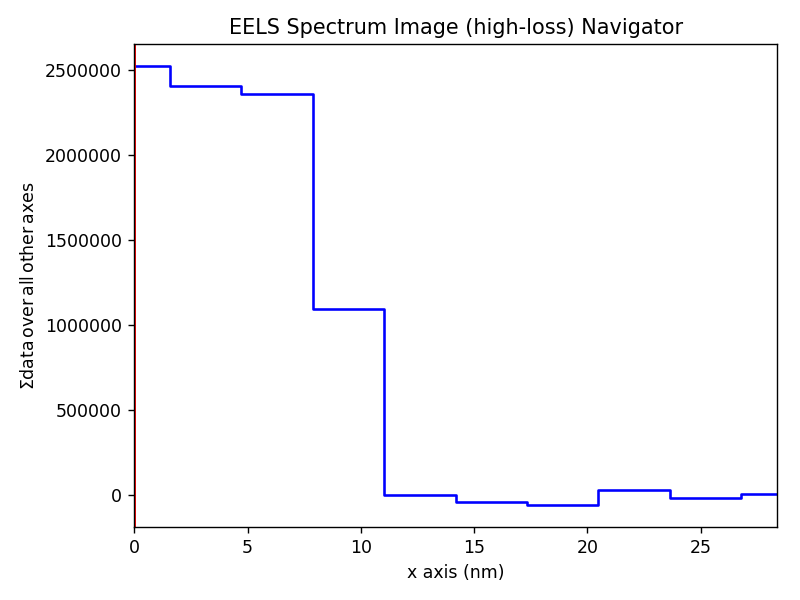

In [15]:
s_ti.plot()

# <a id='curve_fitting_quant'></a> 3. Curve fitting quantification

Now, lets do some more advanced quantification using HyperSpy's extensive modelling framework. Firstly, we load the low loss and core loss spectra.

Firstly we'll have to tell HyperSpy where to find the Digital Micrograph Hartree-Slater cross section files, since they are not included in HyperSpy. This can be done interactively through the preferences GUI by calling `hs.preferences.gui()`. Go to the "EELS" tab, then set "GOS directory" to the "H-S GOS Tables" folder. Note that unfortunately this requires a license of Gatan Digital Micrograph.

Unfortunately, the license of DM does not allow for us to include the GOS files with the notebooks, since they are not for general distribution. 

For the sake of demonstration, the instructor has these files installed locally, and running the cell immediately below this one will tell HyperSpy to look in the `./data/DM_GOS` folder for these files. The machines in the lab should have DM installed, and so we will point to the default installation folder for the files.

If you don't have Digital Micrograph you can still perform curve fitting of K and L edges using Ray Egerton's Hydrogenic cross-sections which are included in HyperSpy, but you will not be able to do detailed fine structure fitting, and will have to watch the instructor's notebook to see how the process works for fine structure fits. The modeling commands will fail unfortunately, because we show the modeling of L and M edges.

In [16]:
# Run this line if you have the GOS files in a custom location
hs.preferences.EELS.eels_gos_files_path = 'data/DM_GOS'

# Run this line if you have a default Gatan DM installation on the same computer this notebook is being run
# hs.preferences.EELS.eels_gos_files_path = 'C:\ProgramData\Gatan\EELS Reference Data\H-S GOS Tables'

In [17]:
s_ll = hs.load("data/LSMO_STO_linescan_low_loss.hdf5")

In [18]:
s = hs.load("data/LSMO_STO_linescan.hdf5")

Here, the metadata has been populated with some of the experimental parameters:

In [19]:
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EELS
│       │       └── collection_angle = 33.100000000000001
│       ├── beam_energy = 200.0
│       ├── convergence_angle = 27.100000000000001
│       └── dwell_time = 0.49990557338919173
├── General
│   ├── original_filename = LSMO_STO_linescan.dm3
│   └── title = EELS Spectrum Image (high-loss)
└── Signal
    ├── binned = True
    ├── signal_origin = 
    └── signal_type = EELS

Firstly we want to fix the zero point for the energy axis using the zero loss peak.

Plot it, and use the zoom functionality (the box button) in the Signal plot to zoom in on the zero loss peak.

It is offset by approximetely 0.6 eV.

<IPython.core.display.Javascript object>


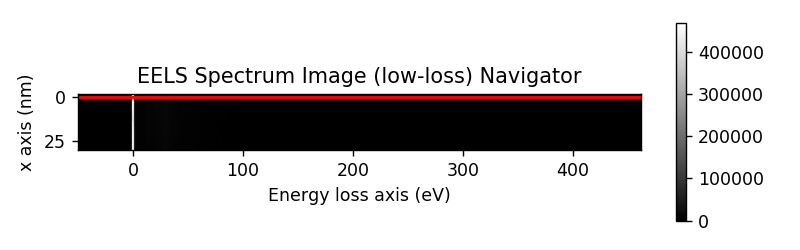

<IPython.core.display.Javascript object>


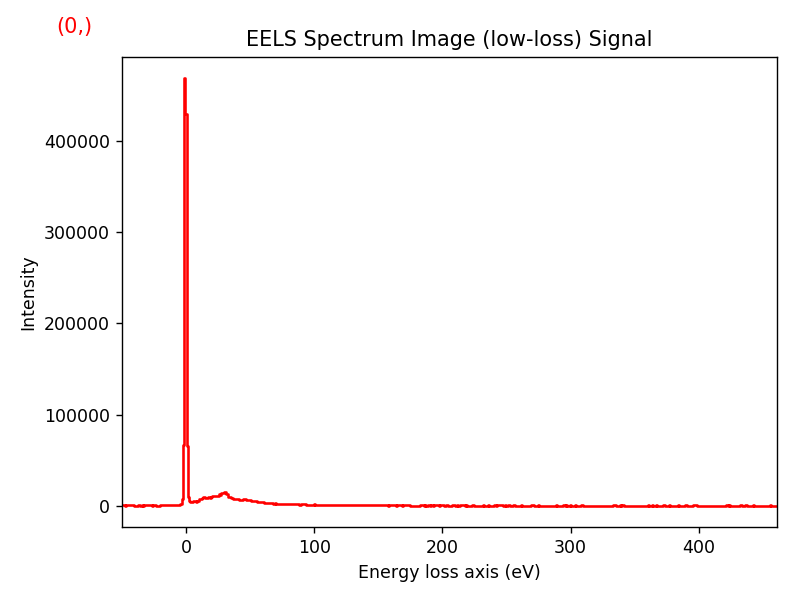

In [20]:
s_ll.plot()

To fix this we use the `align_zero_loss_peak` method. The subpixel argument interpolates the data, so we get sub-pixel alignment. Using the also_align argument, we can also apply the alignment on a another signal. For example when using dualEELS, where both the low loss and core loss is acquired quasi-simultaneously. Note the other signals must have the same navigation shape as the low loss signals.

In [21]:
s_ll.align_zero_loss_peak(subpixel=True, also_align=[s])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	-1
std:	0

min:	-1
Q1:	-1
median:	-1
Q3:	-1
max:	-1


By doing this, we aligned both our low loss and core loss spectra.

<IPython.core.display.Javascript object>


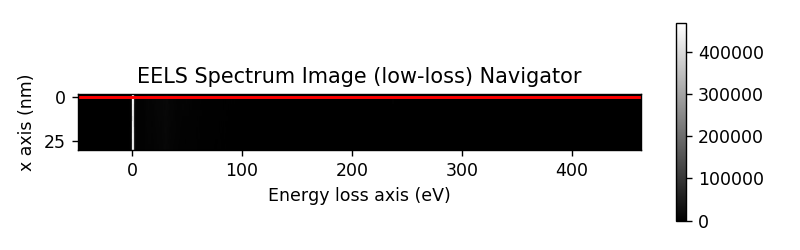

<IPython.core.display.Javascript object>


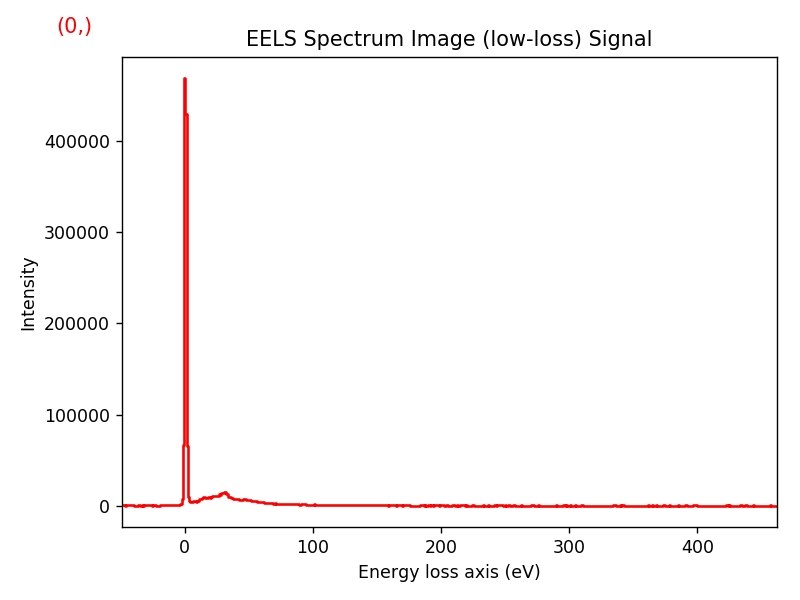

In [22]:
s_ll.plot()

We have to add the elements that are present in the sample `s` to the `Signal` so the right fitting components are automatically generated:

In [23]:
s.add_elements(('Mn','O','Ti','La'))

Then we make a model out of the core loss spectrum. The low loss spectrum is convolved with the model, which means plural scattering is automatically taken into account. In addition this leads to better fits.

**NOTE:** creating this model requires using the GOS files from Gatan Digital Micrograph. If you don't have these files only K and L edges can be created using Hydrogenic cross sections. If you do have them but HyperSpy can't find them in the default location, you can specify the location using `hs.preferences.gui()`.

In [24]:
m = s.create_model(ll=s_ll)

The model new consist of many different `EELSCLEdge` components, including a component for the plasmon background

In [25]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw
   1 |               Ti_L3 |               Ti_L3 |          EELSCLEdge
   2 |               Ti_L2 |               Ti_L2 |          EELSCLEdge
   3 |               Ti_L1 |               Ti_L1 |          EELSCLEdge
   4 |                 O_K |                 O_K |          EELSCLEdge
   5 |               Mn_L3 |               Mn_L3 |          EELSCLEdge
   6 |               Mn_L2 |               Mn_L2 |          EELSCLEdge
   7 |               Mn_L1 |               Mn_L1 |          EELSCLEdge
   8 |               La_M5 |               La_M5 |          EELSCLEdge
   9 |               La_M4 |               La_M4 |          EELSCLEdge

We can fit the model to the experimental data by using the `multifit` function, with the `smart` fitting. Which is fits in a way optimized for EELS data, by fitting from the lowest to the highest energy losses.

In [26]:
m.multifit(kind='smart')

<IPython.core.display.Javascript object>


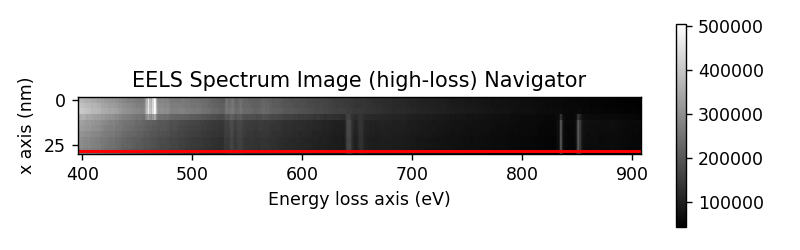

<IPython.core.display.Javascript object>


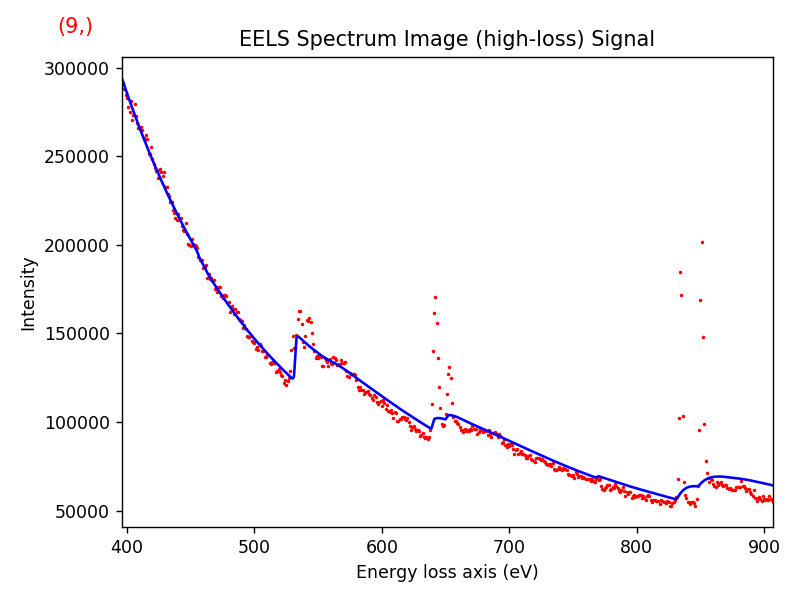

In [27]:
m.plot()

We can check the error of the fitting

In [28]:
edges = ("Ti_L3", "La_M5", "Mn_L3","O_K")

<IPython.core.display.Javascript object>


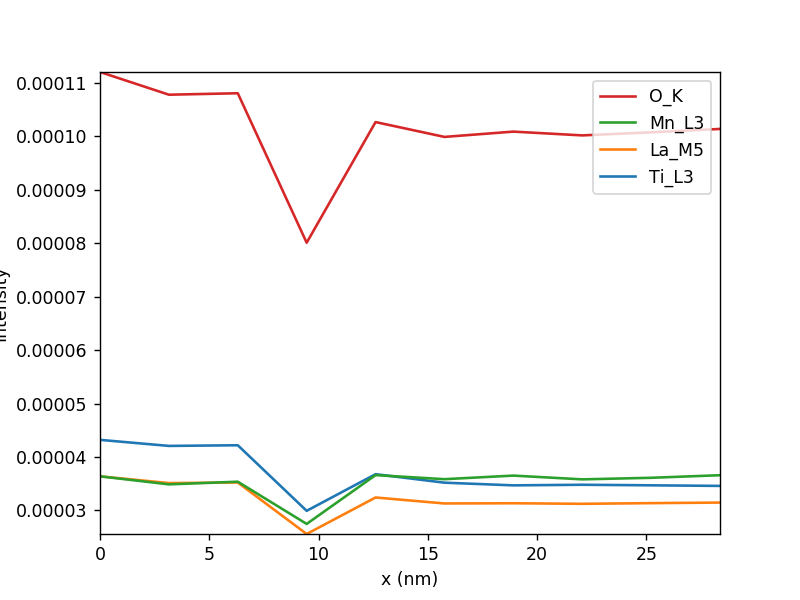

In [29]:
_ = hs.plot.plot_spectra([m[edge].intensity.as_signal("std") for edge in edges], legend=edges)

This fitted mostly ok, but it is still not very good. Firstly we can move the Hartree-Slater onsets interactively

<IPython.core.display.Javascript object>


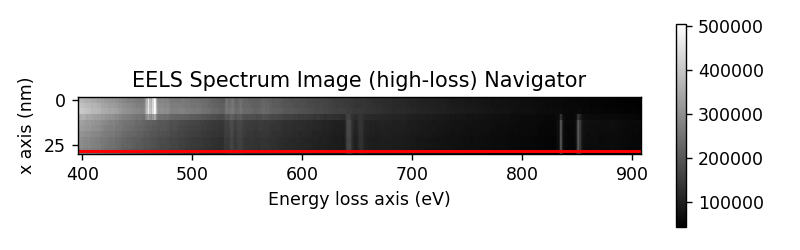

<IPython.core.display.Javascript object>


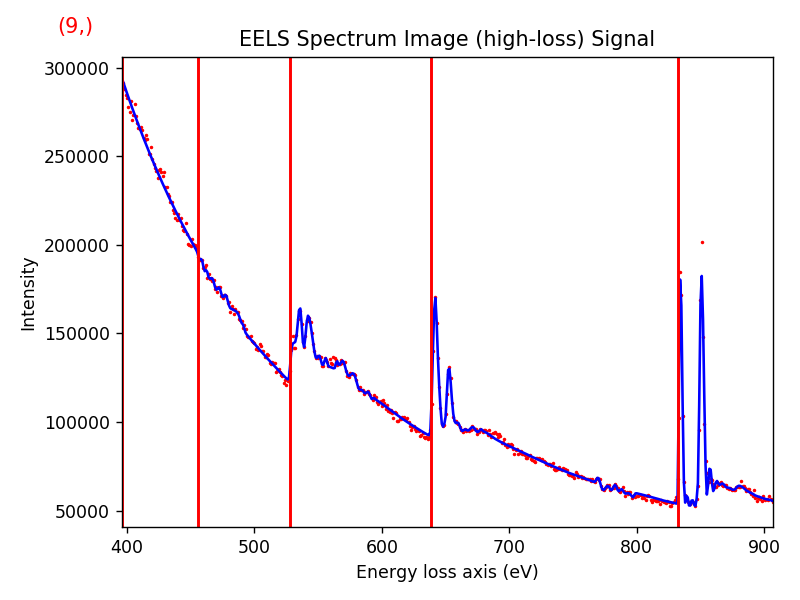

In [30]:
m.plot()
m.enable_adjust_position()

Or manually, by directly changing the parameters within the Hartree-Slater edges. The parameter is called `onset_energy`

In [31]:
m.components.O_K.onset_energy.value = 528

However, to change it for all the probe positions we have to use assign_current_value_to_all()

In [32]:
m.components.O_K.onset_energy.assign_current_value_to_all()

We repeat this for the Manganese edges. Since this is an _L_ edge, there are 3 different ones. However, we only have to set the Mn-L<sub>3</sub>: the L<sub>2</sub> and L<sub>1</sub> energies are set to an energy relative to the L<sub>3</sub>.

In [33]:
m.components.Mn_L3.onset_energy.value

640.0

In [34]:
m.components.Mn_L2.onset_energy.value

651.0

In [35]:
m.components.Mn_L3.onset_energy.value = 638.5

In [36]:
m.components.Mn_L2.onset_energy.value 

649.5

In [37]:
m.components.Mn_L3.onset_energy.assign_current_value_to_all()

The bad fitting to the data is also due to the fine structure not currently taken into account by the model. To get a good fit, we can either not fit to the fine structure regions, or model them somehow.
The easiest way is defining certain regions as fine structure:

In [38]:
m.enable_fine_structure()

This will produce a much better fit, but will be much slower (~2 minutes on a modern 2018 laptop; 3.5 minutes on lab computer).

In [39]:
m.multifit(kind='smart')

C:\Users\jat\anaconda3\envs\zs_tomo\lib\site-packages\hyperspy\model.py:1131: RuntimeWarning: invalid value encountered in sqrt
  self.p_std = np.sqrt(np.diag(pcov))


Now the fit is much better, due to the model taking into account the fine structure.

<IPython.core.display.Javascript object>


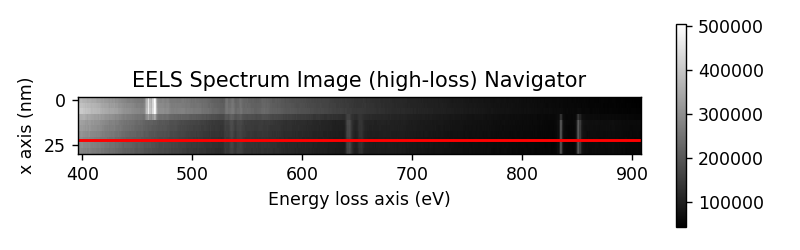

<IPython.core.display.Javascript object>


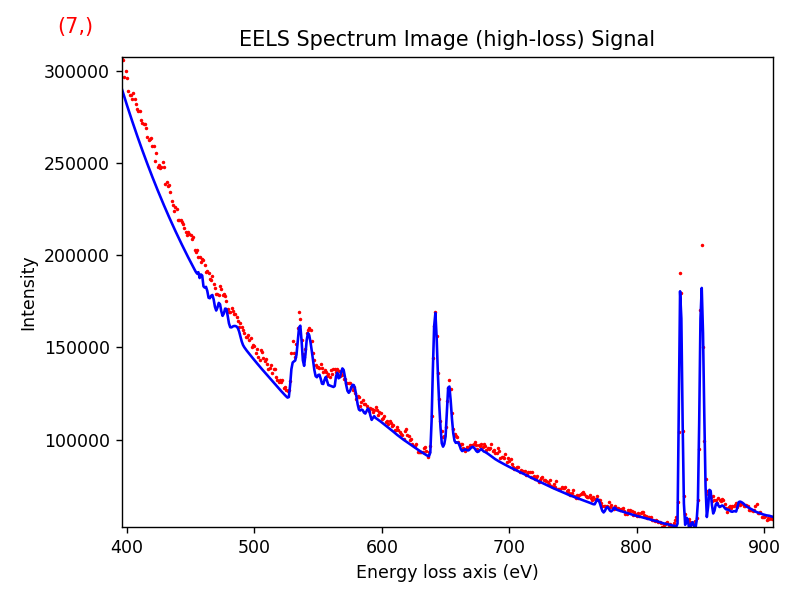

In [40]:
m.plot()

Now we can can have a look at the relative intensity from the individual EELS-edges using the `plot_spectra` method:

In [41]:
edges = ("Ti_L3", "La_M5", "Mn_L3","O_K")

<IPython.core.display.Javascript object>


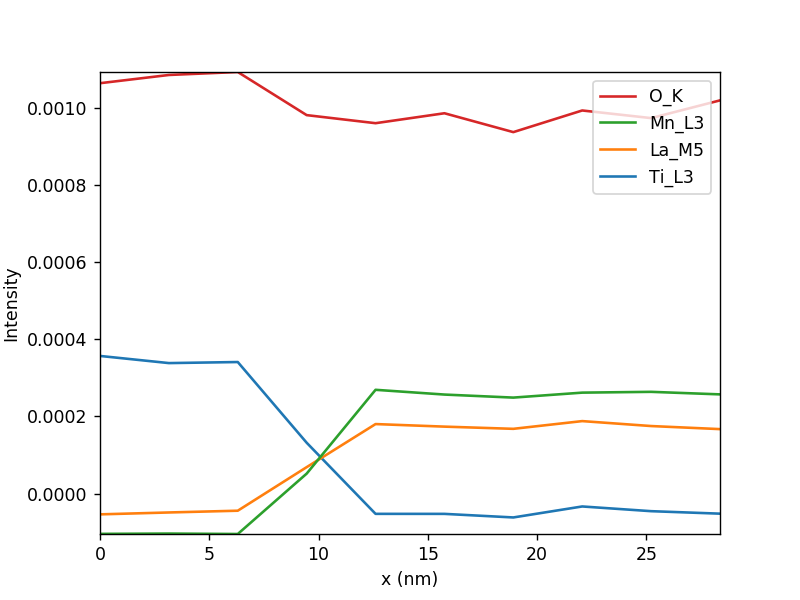

In [42]:
_ = hs.plot.plot_spectra([m[edge].intensity.as_signal() for edge in edges], legend=edges)

While the fitting looks nicer, we can clearly improve this. Firstly the intensities are negative where it should be zero. Secondly, the fine structure regions can be fine tuned. Especially the Mn-*L*<sub>1</sub> fine structure window can be reduced

In [43]:
m.components.Mn_L1.fine_structure_width = 15

To avoid the negative values we use bounded fitting, where we can constrain the parameter values between certain values. The `bmin` and `bmax` properties in the parameters are used for this.

In [44]:
m.components.Mn_L3.intensity.bmin = 0.0

In [45]:
m.components.La_M5.intensity.bmin = 0.0

In [46]:
m.components.Ti_L3.intensity.bmin = 0.0

In [47]:
m.components.O_K.intensity.bmin = 0.0

We fit again, this time with bounded parameters (this will be faster, but still takes about 2 minutes on the lab computers):

In [48]:
m.multifit(fitter="leastsq", kind='smart', bounded=True)

<IPython.core.display.Javascript object>


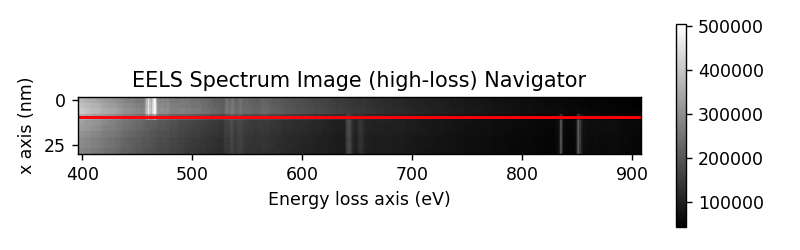

<IPython.core.display.Javascript object>


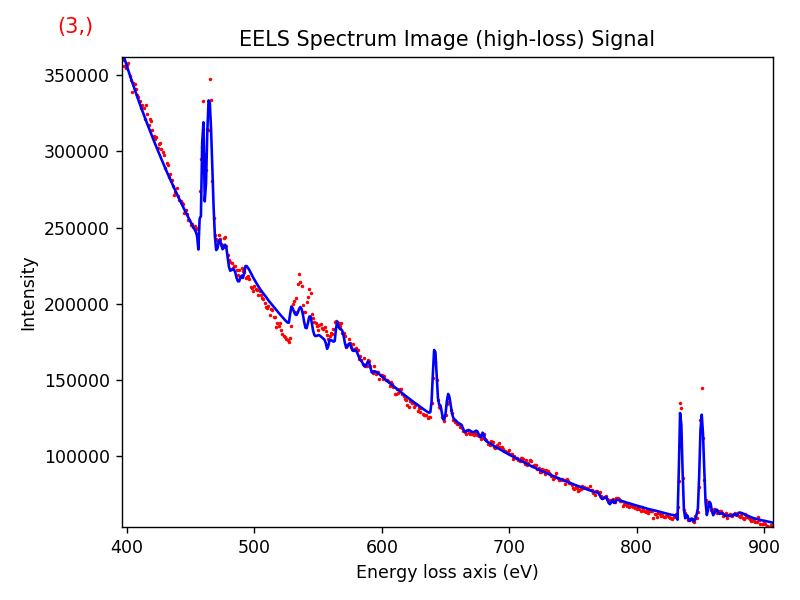

In [49]:
m.plot()

<IPython.core.display.Javascript object>


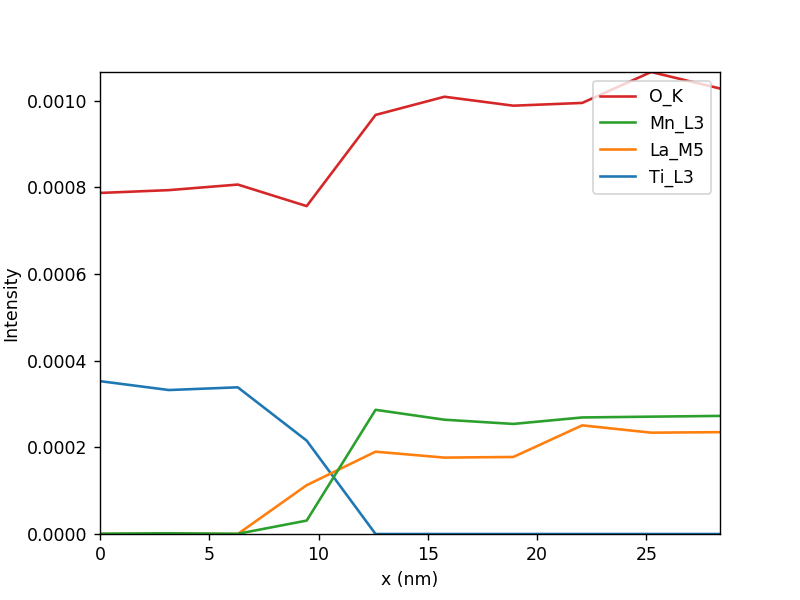

In [50]:
_ = hs.plot.plot_spectra([m[edge].intensity.as_signal() for edge in edges], legend=edges)

# <a id='fine_structure_analysis'></a> 4. Fine structure analysis

Here we take a look at a linescan from a La<sub>0.7</sub>Sr<sub>0.3</sub>MnO<sub>3</sub> thin film, where parts of the film has been bombarded with the electron beam for an extended time.

In [51]:
s = hs.load("data/LSMO_linescan.hdf5")

Using the moving the red line in the there is clearly something going on in the middle on both the oxygen (532 eV) and the manganese (629 eV) edges. In addition, there are some thickness changes during the line scan.

<IPython.core.display.Javascript object>


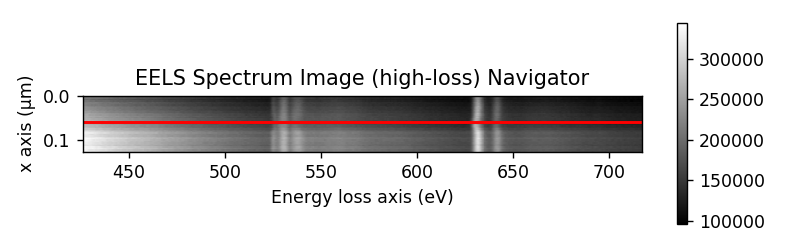

<IPython.core.display.Javascript object>


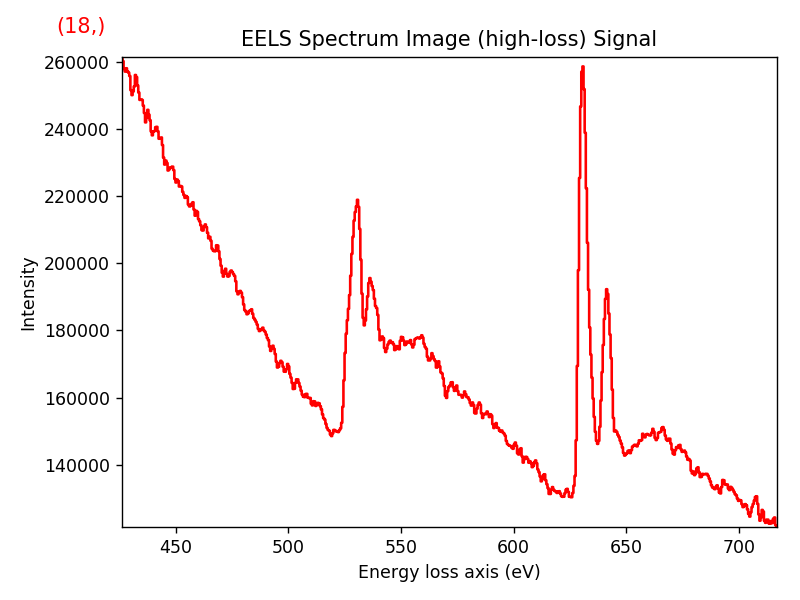

In [48]:
s.plot()

Using the low loss signal, we make sure the energy scale is properly calibrated

In [49]:
s_ll = hs.load("data/LSMO_linescan_low_loss.hdf5")

<IPython.core.display.Javascript object>


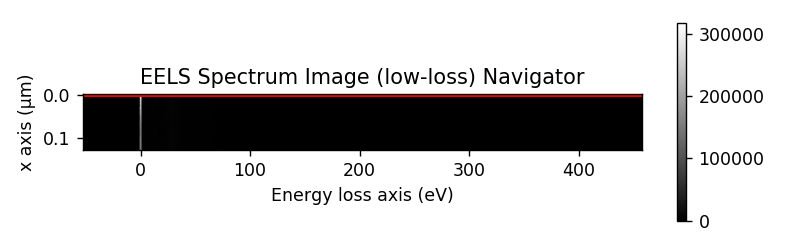

<IPython.core.display.Javascript object>


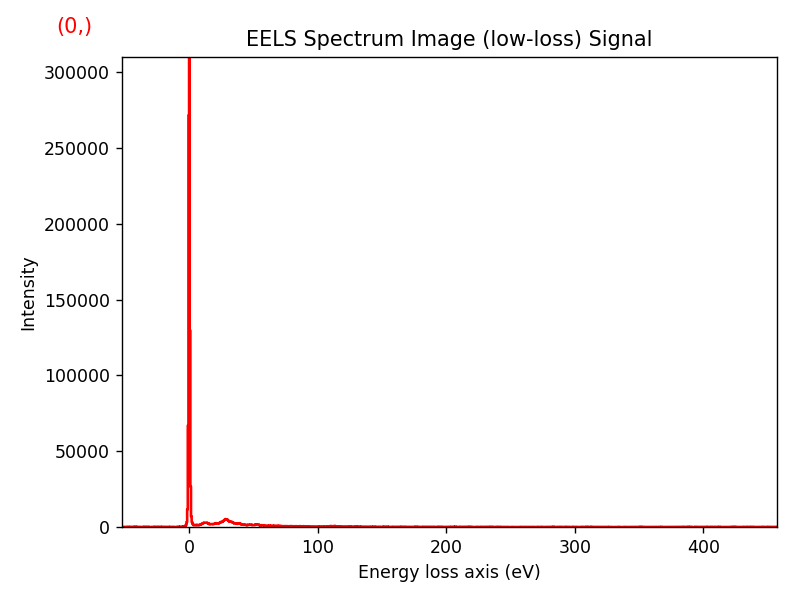

In [50]:
s_ll.plot()

The zero loss peak is not well aligned at 0 eV energy loss, so we should align it and the core loss

In [51]:
s_ll.align_zero_loss_peak(also_align=[s])


Initial ZLP position statistics
-------------------------------
Summary statistics
------------------
mean:	3.23
std:	0.249

min:	3
Q1:	3
median:	3
Q3:	3.5
max:	3.5


Now the zero loss peak has been shifted to 0 energy loss, and likewise the core loss spectrum `s` has also been aligned

<IPython.core.display.Javascript object>


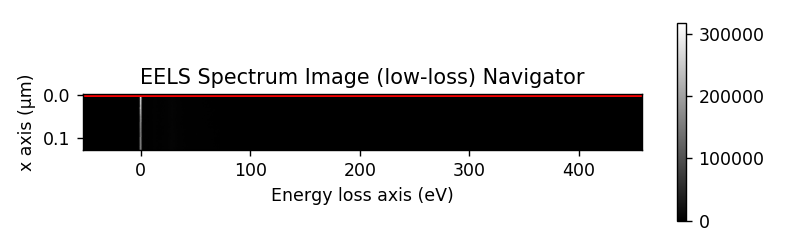

<IPython.core.display.Javascript object>


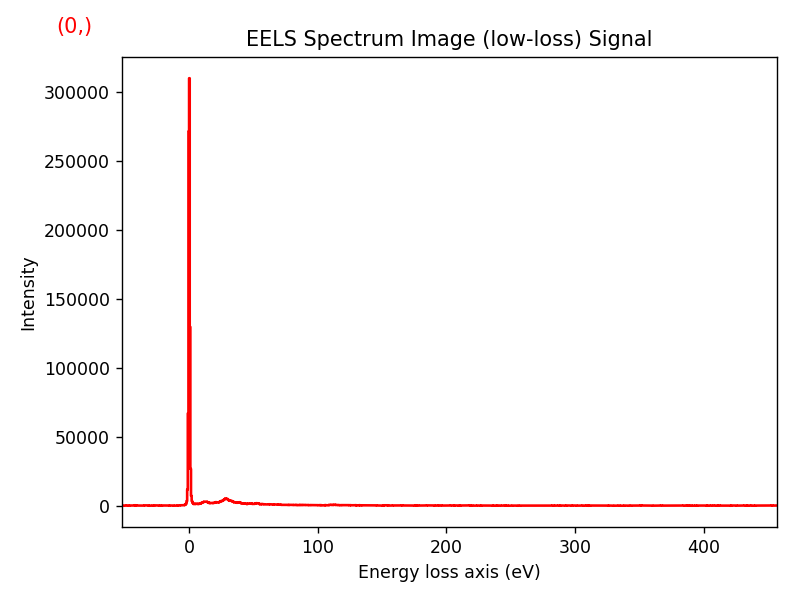

In [52]:
s_ll.plot()

We can also calculate the relative thickness using the low loss. We'll have to specify the end of the zero loss peak. For cold field emissions guns, 3.5 eV seems to work well. The `estimate_elastic_scattering_threshold()` method can also be used to find this value:

In [53]:
s_ll.estimate_elastic_scattering_threshold().data

array([ 10.5,   3.5,   4. ,   5. ,   4. ,   3.5,   3. ,   4.5,   3.5,
         4. ,   5. ,   3.5,   4. ,   5. ,   4. ,   3.5,   3.5,   4. ,
         4. ,   3.5,   6. ,   4. ,   4. ,   3.5,   3.5,   5. ,   3.5,
         3. ,   3. ,   3. ,   4.5,   4. ,   3.5,   3. ,   5.5,   4. ,
         3.5,   7. ,   3.5,   3.5])

In [54]:
s_thickness = s_ll.estimate_thickness(threshold=3.5) 

This gives the relative thickness and, as expected, there is an increase towards the end of the line scan

<IPython.core.display.Javascript object>


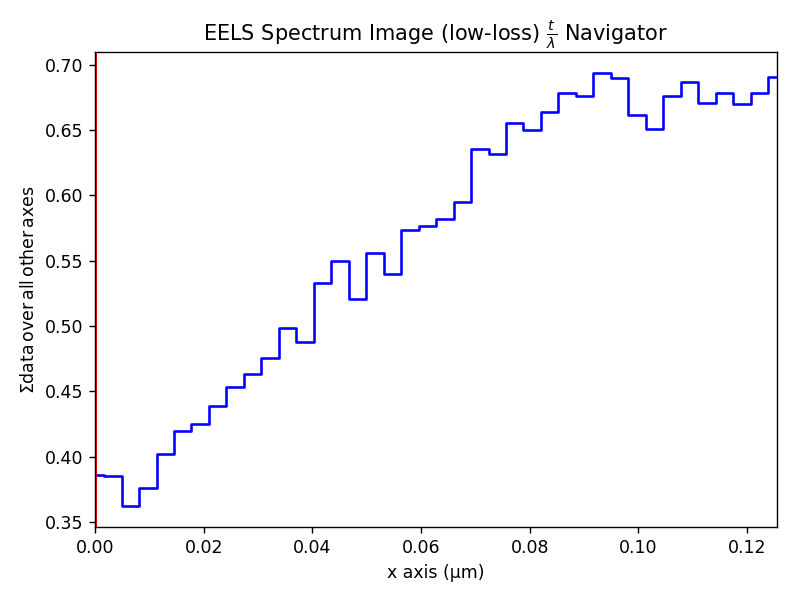

In [55]:
s_thickness.plot()

# <a id='fine_structure_ok'></a> 5. Fine structure: Oxygen *K*-edge
Lets take a closer look at the O-_K_ edge, firstly by removing the plasmon background, then cropping the spectrum to only include the O-*K* edge. Note: this will overwrite the `s` spectrum with the cropped one. 

<IPython.core.display.Javascript object>


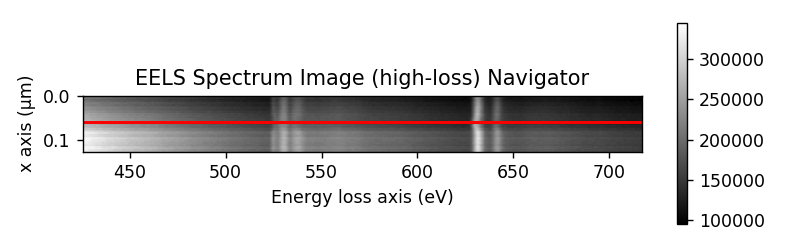

<IPython.core.display.Javascript object>


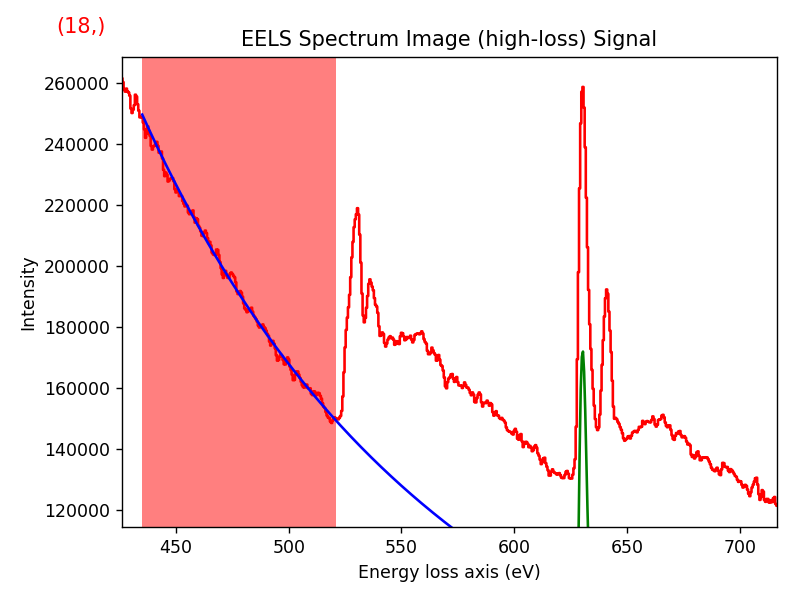

<IPython.core.display.Javascript object>


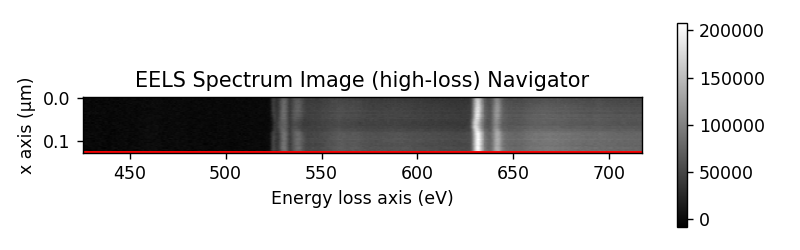

<IPython.core.display.Javascript object>


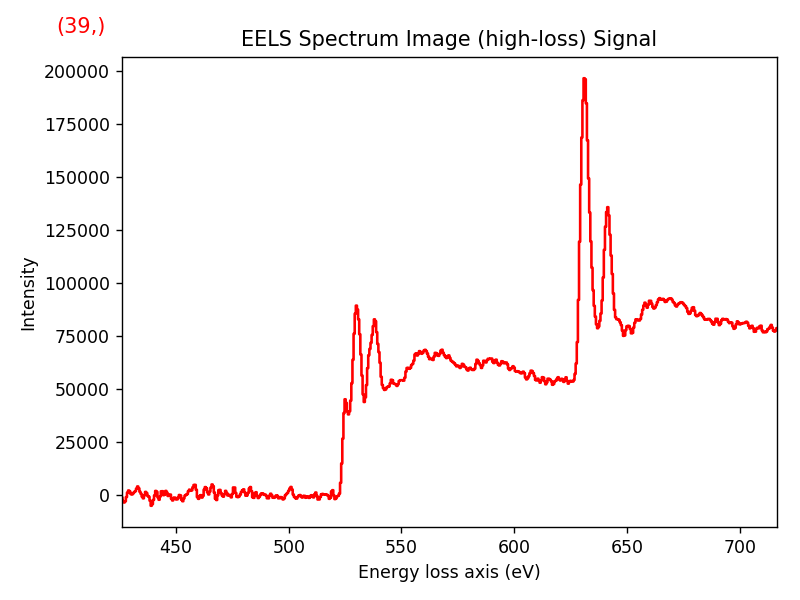

In [56]:
s.remove_background(fast=False)

This makes it much easier to compare the different positions. Pressing `e` with the spectrum window highlighted gives a second spectrum picker, which can be moved independently of the first one so the two regions can be compared.

We can then do Fourier ratio deconvolution to remove the effects of plural scattering

In [57]:
s_deconvolved = s.fourier_ratio_deconvolution(s_ll)

<IPython.core.display.Javascript object>


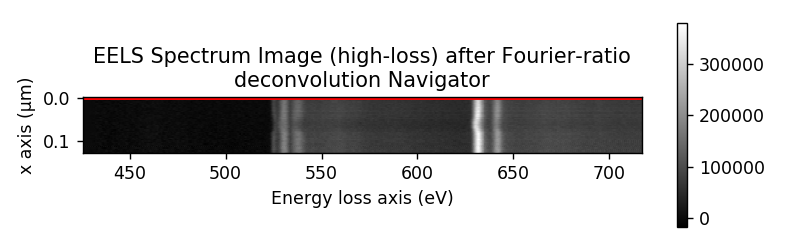

<IPython.core.display.Javascript object>


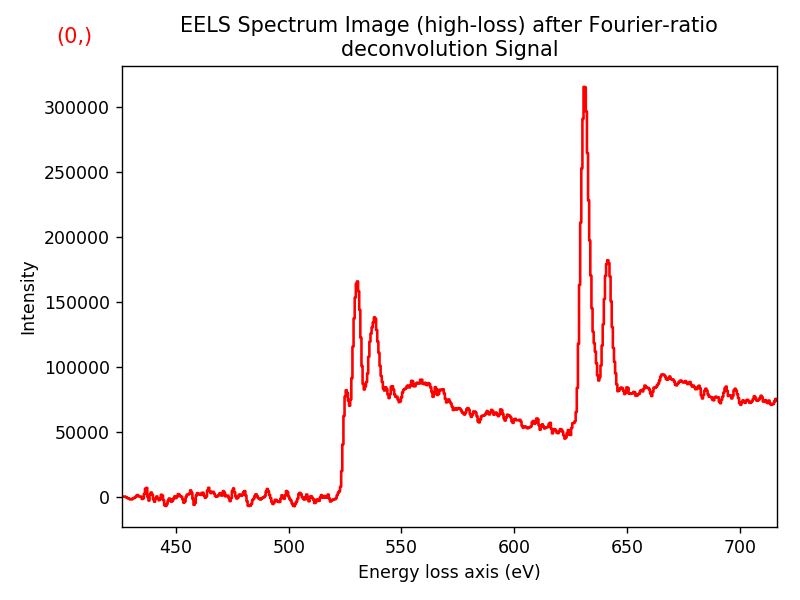

In [58]:
s_deconvolved.plot()

### Fine structure modelling

Having had a qualitatively look at the data, we can try to quantify some of these changes. We do this by making making a model of the O-_K_ edge signal. Firstly we crop the signal, leaving only the O-*K* edge (490 to 590 eV).

<IPython.core.display.Javascript object>


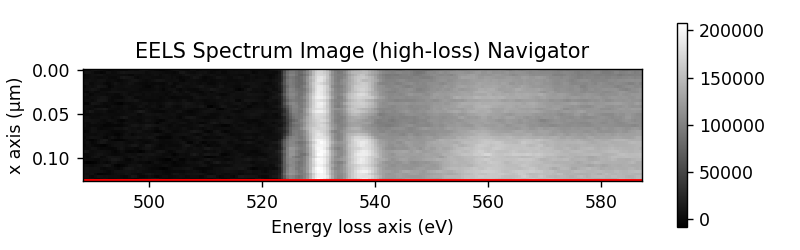

<IPython.core.display.Javascript object>


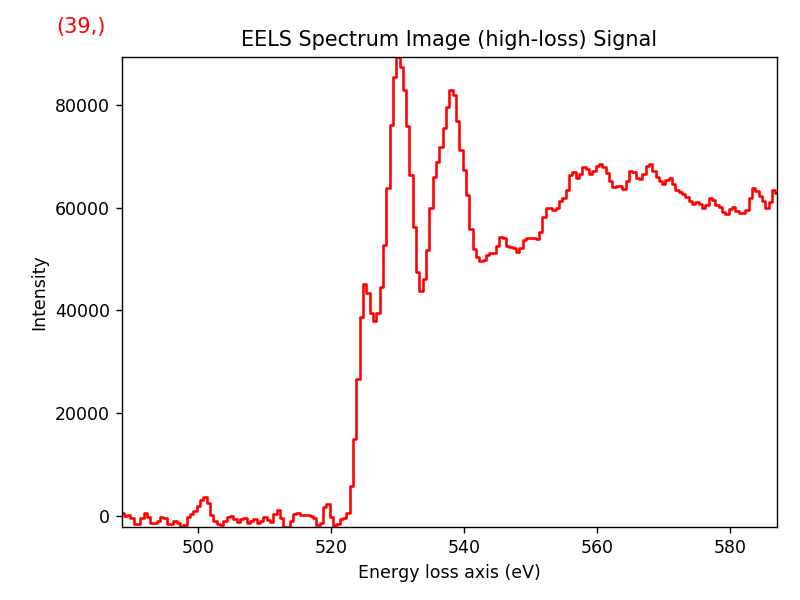

In [59]:
s.crop_signal1D()

As we've already removed the background, we set `auto_background=False` for the model. In addition, since we haven't added any elements to the signal, we have no ionization edges.

In [60]:
m = s.create_model(ll=s_ll, auto_background=False)

So currently, the model does not contain any components

In [61]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------

We can try to model some of the fine structure with Gaussians

In [62]:
g1 = hs.model.components1D.Gaussian()

In [63]:
m.append(g1)

This added the gaussian component to the model

In [64]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            Gaussian |            Gaussian |            Gaussian

Then we can fit this Gaussian to the largest of the O-K peaks by dragging a span over the peak between 528 and 533 eV. Run it first with the "Only Current" option ticked, then run it without to fit the whole dataset

<IPython.core.display.Javascript object>


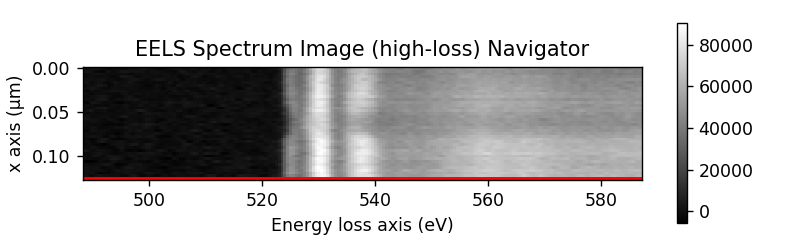

<IPython.core.display.Javascript object>


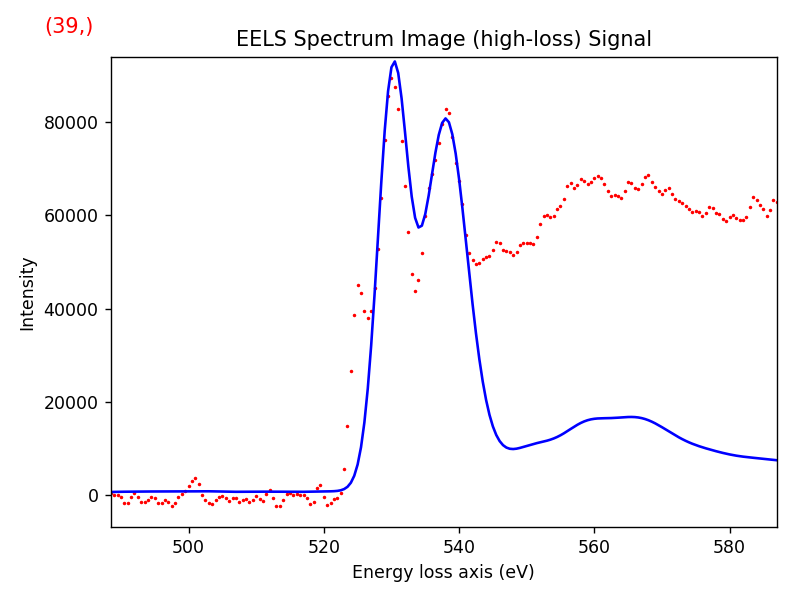

In [65]:
m.fit_component(g1)

Having fitted the Gaussian to the experimental data, we can plot how the Gaussian three parameters change over the line scan: `A`, `sigma` and `centre`. The `A` changes quite a bit, which is probably (among others) related to thickness changes. However, there are clear changes in the sigma parameter in the region with the electron beam damage

<IPython.core.display.Javascript object>


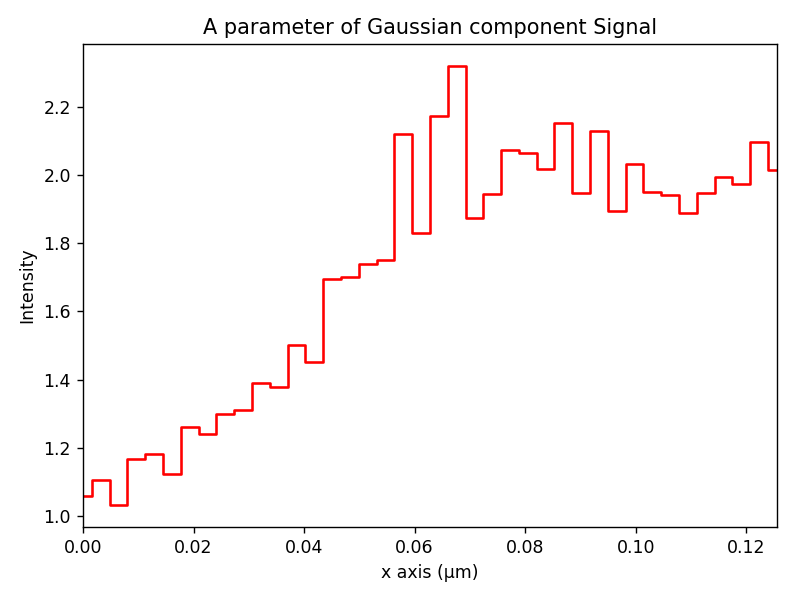

<IPython.core.display.Javascript object>


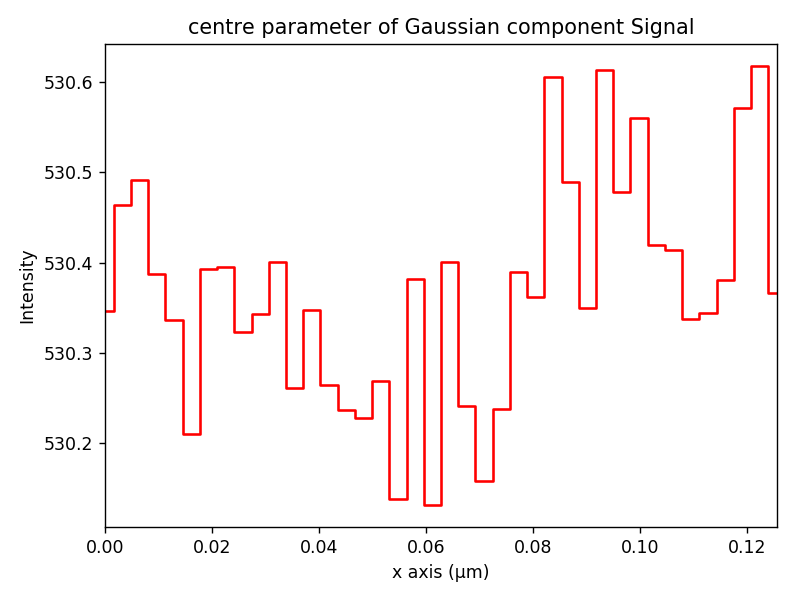

<IPython.core.display.Javascript object>


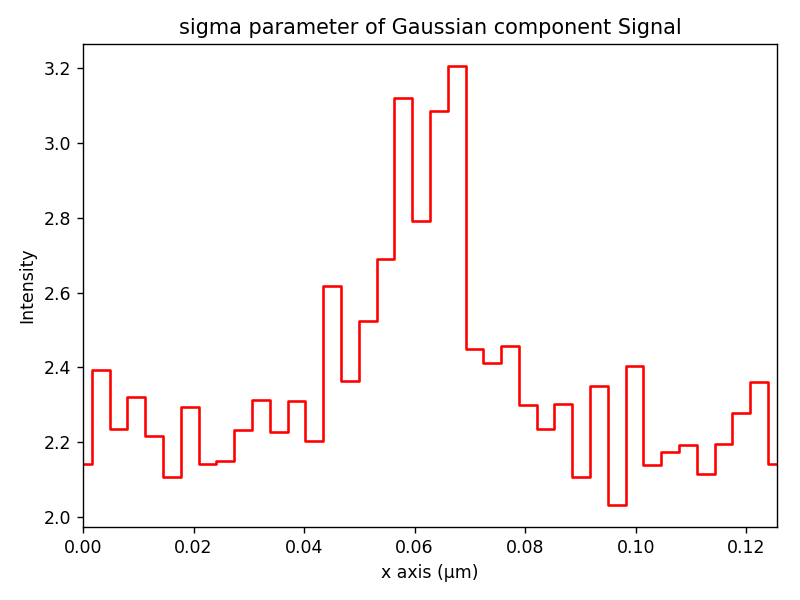

In [66]:
g1.plot()

Using the same method we can also fit the second largest peak between 535 and 541 eV. Using the `signal_range` argument we don't have to select the region using the GUI.

In [67]:
g2 = hs.model.components1D.Gaussian()

In [68]:
m.extend([g2])

In [69]:
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            Gaussian |            Gaussian |            Gaussian
   1 |          Gaussian_0 |          Gaussian_0 |            Gaussian

In [70]:
m.fit_component(g2, signal_range=(535.,541.), only_current=False)

<IPython.core.display.Javascript object>


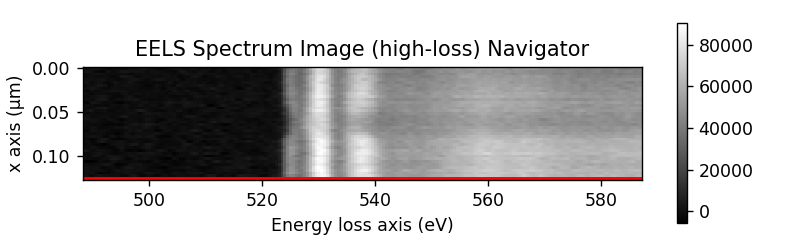

<IPython.core.display.Javascript object>


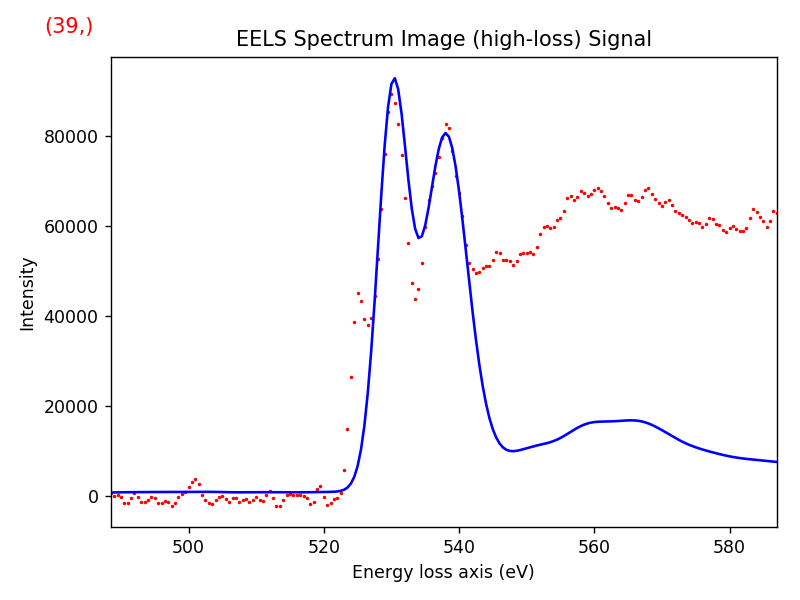

In [71]:
m.plot()

However, this time the final fit does not look very good. This is due to the two components being fitted independently of each other. We should fit both of them at the same time. Firstly, we have to set the `signal_range` which is where the model will fit to the experimental data. Here we select the region spanning the two major peaks (528-541 eV)

<IPython.core.display.Javascript object>


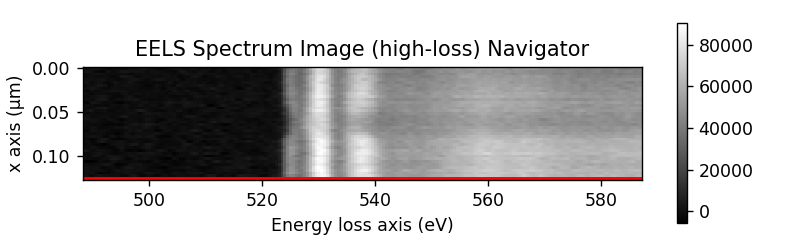

<IPython.core.display.Javascript object>


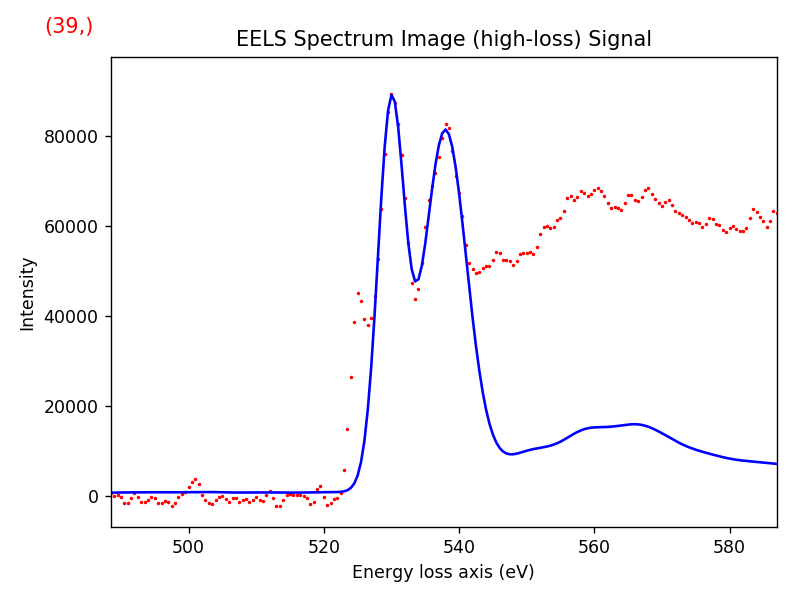

In [72]:
m.set_signal_range()

In [73]:
m.multifit()

After fitting, we reset the signal range so we can see the full range of the signal

In [74]:
m.reset_signal_range()

<IPython.core.display.Javascript object>


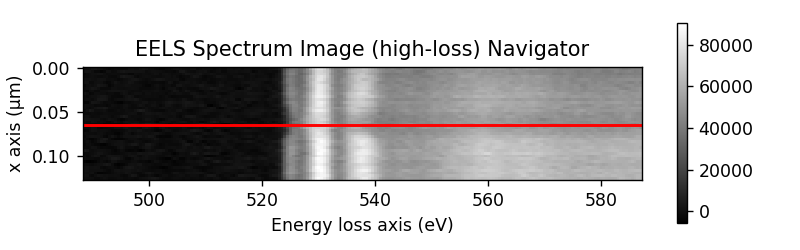

<IPython.core.display.Javascript object>


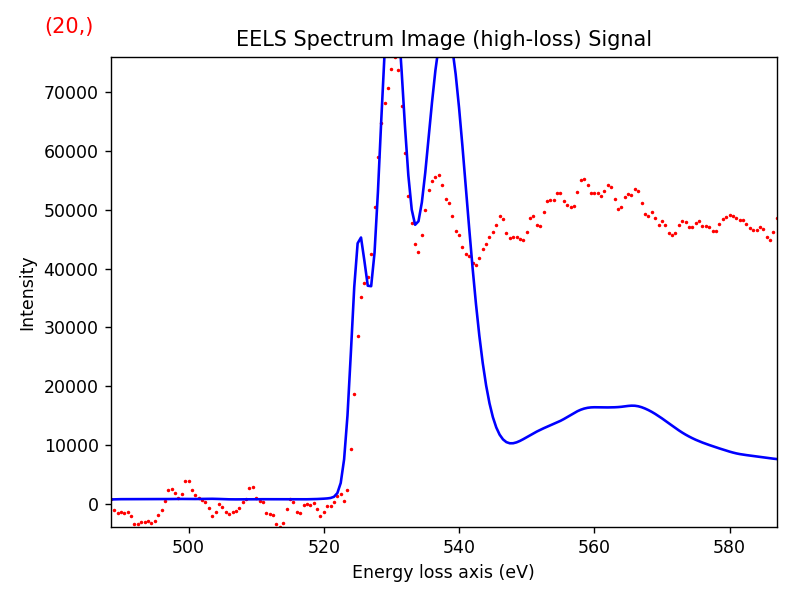

In [75]:
m.plot()

Lastly, we can fit the small "pre-peak" as well. First we "lock" the two Gaussian we have already fitted.

In [76]:
g1.set_parameters_not_free()

In [77]:
g2.set_parameters_not_free()

Then we add another Gaussian, and fit it using `fit_component` between 522 and 527 eV

In [78]:
g3 = hs.model.components1D.Gaussian()

In [79]:
m.append(g3)

In [80]:
m.fit_component(g3, signal_range=(522., 527.), only_current=False)

Then we set the signal range to cover all the three peaks, from 520 eV to 541 eV

In [81]:
m.set_signal_range(520.,541.)

And set the g1 and g2 components free

In [82]:
g1.set_parameters_free()

In [83]:
g2.set_parameters_free()

In [84]:
m.multifit()

This fits all the three components to the experimental data, which hopefully gives a good fit

In [85]:
m.reset_signal_range()

<IPython.core.display.Javascript object>


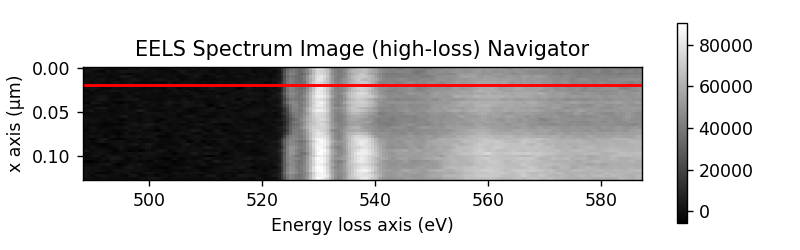

<IPython.core.display.Javascript object>


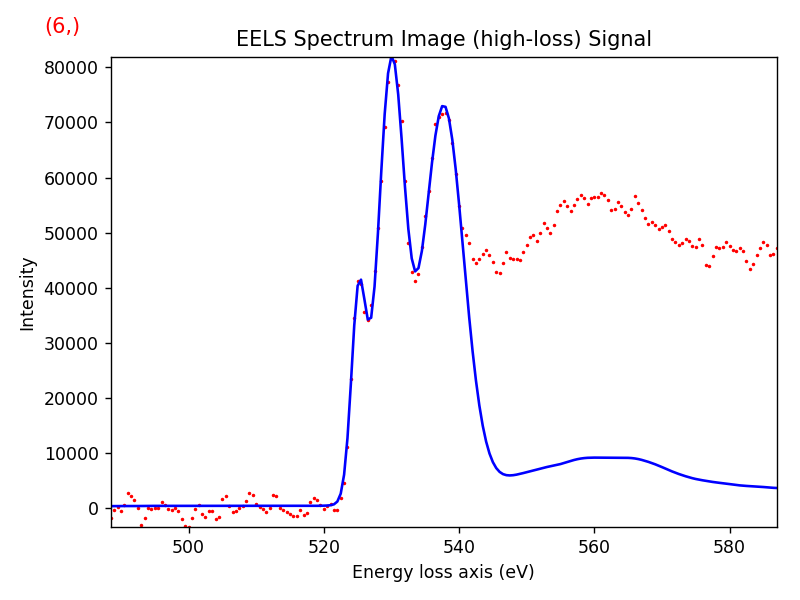

In [86]:
m.plot()

We can then compare the different parameters in the components

In [87]:
g1_g3_ratio = g1.A.as_signal()/g3.A.as_signal()

C:\Users\jat\anaconda3\envs\zs_tomo\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


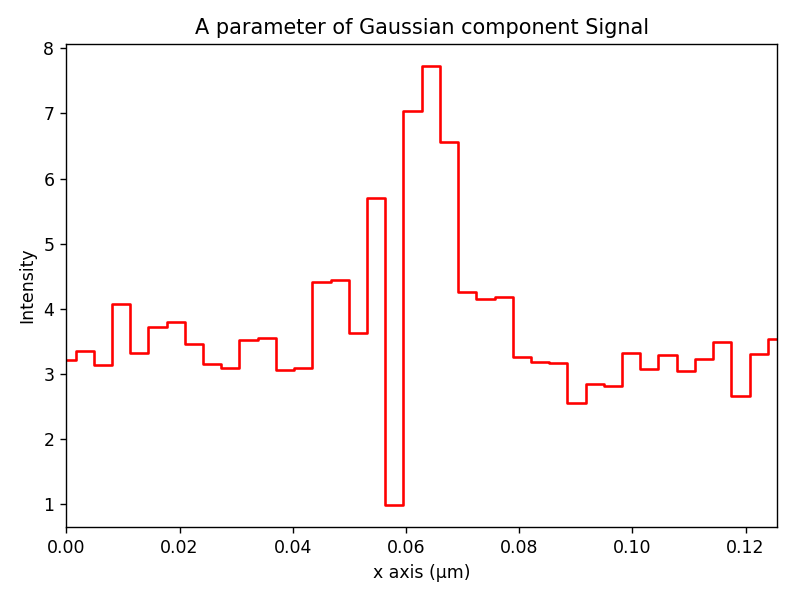

In [88]:
g1_g3_ratio.plot()

In [91]:
g1_g3_position = g1.centre.as_signal()-g3.centre.as_signal()

<IPython.core.display.Javascript object>


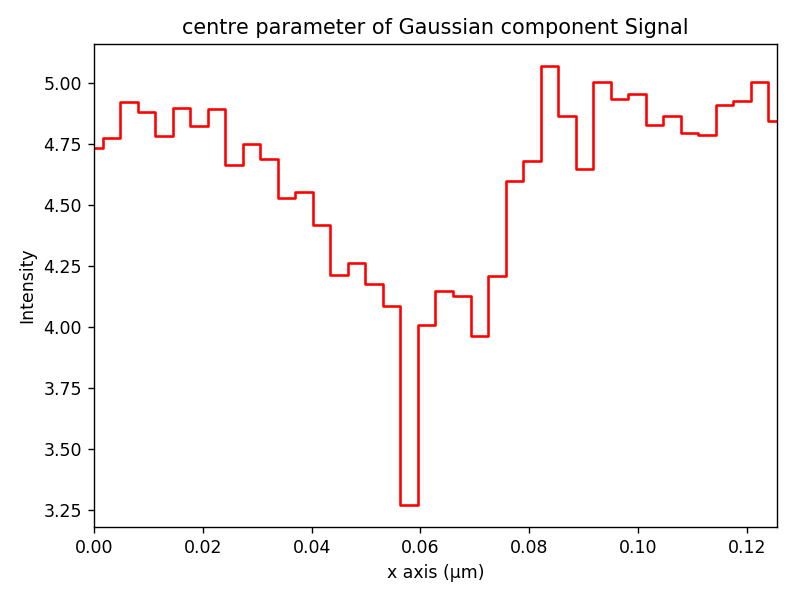

In [92]:
g1_g3_position.plot()

In [93]:
g1_g3_sigma = g1.sigma.as_signal()/g3.sigma.as_signal()

C:\Users\jat\anaconda3\envs\test_hyperspy\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


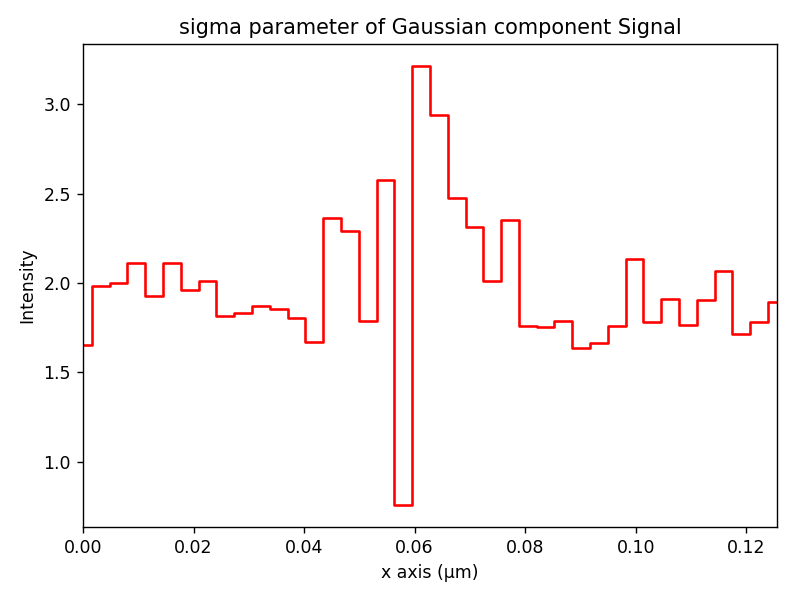

In [94]:
g1_g3_sigma.plot()

In all of the comparisons there are some large changes in the regions with beam damage. However, the values can vary a great deal. This is most likely due to the g1 fitted to the pre-peak is not so clearly defined in these regions. Leading to potentially bad fitting.